In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
from spacy.matcher import Matcher 
from collections import  Counter
import matplotlib.pyplot as plt
from spacy.tokens import Span 
import tensorflow_hub as hub
from rake_nltk import Rake
import tensorflow as tf
import pyLDAvis.gensim
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import pyLDAvis
import gensim
import spacy
import os
import gc

C:\Users\JBARCO\Anaconda3\lib\site-packages\gensim\corpora\dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
C:\Users\JBARCO\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
from sqlalchemy import create_engine

# follows django database settings format, replace with your own settings
DATABASES = {
       'produccion':{
        'NAME': 'bd_biblioteca',
        'USER': 'postgres',
        'PASSWORD': 'postgres1',
        'HOST': 'localhost',
        'PORT': 5433
    }
}

db_produccion= DATABASES['produccion']


prod_engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db_produccion['USER'],
    password = db_produccion['PASSWORD'],
    host = db_produccion['HOST'],
    port = db_produccion['PORT'],
    database = db_produccion['NAME'],
)

prod= create_engine(prod_engine_string)

In [25]:
sql="select m.*, contenido,grupo from fn_distancia_milikowski(7696) m join documento d on d.id_documento=m.id_documento join documentos_grupo gr on d.id_documento=gr.id_documento where distancia<0.2 and d.id_documento<>8169 order by distancia;"
df_tesis=pd.read_sql(sql,prod)
prod.dispose()
df_tesis

,id_documento,distancia,contenido,grupo
0,5268,0.000630,Pg_KDD - Entorno Gráfico para el Sistema de De...,11
1,446,0.000678,IMPLANTACIÓN DE PRIMITIVAS SQL PARA EL DESCUBR...,11
2,183,0.003327,MATE-KDD: UNA HERRAMIENTA GENÉRICA PARA EL DES...,11
3,4081,0.009654,1\nEXDACLET: HERRAMIENTA DE DATACLEANING BASAD...,11
4,4130,0.036391,RASEMUS: UNA HERRAMIENTA PARA EL DESCUBRIMIENT...,11
5,6975,0.132021,POLARIS \n\nHERRAMIENTA DE MINERIA DE USO PARA...,11
6,6206,0.153723,GRFPOSTGRES – HERRAMIENTA GRÁFICA PARA EL MOTO...,11
7,5044,0.155544,STARCUBE: Una herramienta ROLAP de análisis mu...,11


In [28]:
import pandas as pd
from ftfy import fix_encoding
import spacy
import spacy.cli
from string import punctuation
from nltk.corpus import stopwords


nlp = spacy.load('es_core_news_sm')
stop=set(stopwords.words('spanish'))

non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(stop)
non_words.extend(map(str,range(10)))



def limpiar(text):
  text=text.lower()
  doc = nlp(text,disable = ['ner', 'parser'])
  #lemmas = [t.norm_ for t in doc if not t.is_punct | t.is_stop and t not in stop]
  lemmas = [t.norm_ for t in doc if not t.is_punct | t.is_stop ]
  words = [t.lower() for t in lemmas if len(t) > 3 and t.isalpha()]
  return ' '.join(words)

nlp.max_length = 10000000 
#df_tesis['contenido'] = df_tesis.apply(lambda row: fix_encoding(row['resumen']),axis=1)
df_tesis['contenido'] = df_tesis.apply(lambda row: limpiar(row['contenido']),axis=1)

In [29]:
df_tesis

,id_documento,distancia,contenido,grupo
0,5268,0.000630,entorno gráfico sistema descubrimiento conocim...,11
1,446,0.000678,implantación primitivas descubrimiento reglas ...,11
2,183,0.003327,mate herramienta genérica descubrimiento regla...,11
3,4081,0.009654,exdaclet herramienta datacleaning basada agent...,11
4,4130,0.036391,rasemus herramienta descubrimiento conocimient...,11
5,6975,0.132021,polaris herramienta mineria polaris herramient...,11
6,6206,0.153723,grfpostgres herramienta gráfica motor base dat...,11
7,5044,0.155544,starcube herramienta rolap análisis multidimen...,11


In [20]:
#Leer grupos trabajo
df_grupos=pd.read_csv("./tesis_grupos.csv",sep="|")
df_grupos=df_grupos[['id_documento','grupo']]
df_grupos

,id_documento,grupo
0,1,23
1,2,34
2,3,27
3,4,20
4,5,12
...,...,...
8100,8167,11
8101,8169,11
8102,8170,6
8103,8171,11


In [19]:
#leer resumenes
df=pd.read_csv("./resumenes_limpios.csv",index_col=0,sep='|')
df = df.dropna().drop_duplicates()
df

FileNotFoundError: [Errno 2] File ./resumenes_limpios.csv does not exist: './resumenes_limpios.csv'

In [15]:
#Cruzar Textos
df_tesis= pd.merge(df, df_grupos, on='id_documento')
df_tesis

,id_documento,contenido,grupo
0,1,monica patricia solis urbano jaime mejia jurad...,23
1,2,juan pasto junio agradecimientos contribuido d...,34
2,3,aura cecilia torres burbano universidad nariño...,27
3,4,nota aceptación firma presidente jurado firma ...,20
4,5,herrera erazo omar ortiz rosero universidad na...,12
...,...,...,...
8100,8167,universidad manizales facultad ciencias ingeni...,11
8101,8169,clasificacion modelo clasificacion tipos probl...,11
8102,8170,introduction this document designed reference ...,6
8103,8171,maskana gestor conocimiento recuperación búsqu...,11


# Palabras mas frecuentes por grupo o dominio

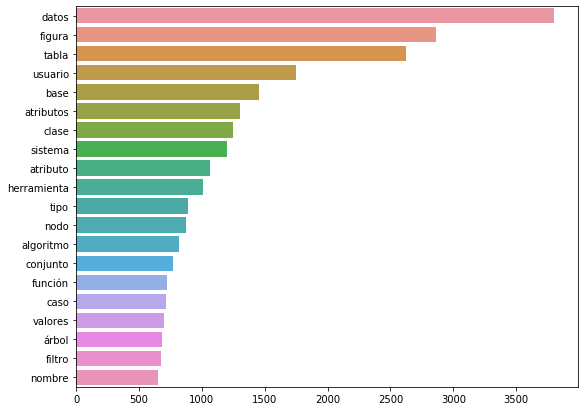

In [30]:
#palabras mas comunes por grupos
grupo=11
stop=set(stopwords.words('spanish'))

def build_list(df,col="contenido"):
    corpus=[]
    lem=WordNetLemmatizer()
    stop=set(stopwords.words('spanish'))
    new= df[col].dropna().str.split()
    new=new.values.tolist()
    corpus=[lem.lemmatize(word.lower()) for i in new for word in i if(word) not in stop]
    
    return corpus

corpus=build_list(df_tesis[df_tesis.grupo==grupo])
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:20]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)
plt.savefig('./Imagenes/grupo_'+str(grupo)+'.png')

#grupo 0 historia sociedad
#grupo 1 medio ambiente h20 suelos territorio 
#grupo 2 cultivos suelos plantas y especies agro
#grupo 3 aprendizaje docente 
#grupo 4 datos y sistemas 
#grupo 5 empresas y organizaciones
#grupo 6 idioma ingles 
#grupo 7 salud animal veterinaria y soctecnia
#grupo 8 aprendizaje en estudiantes
#grupo 9 contruccion y obras civiles 
#grupo 10 actos humanos
#grupo 11 desarrollo software base de datos 
#grupo 12 comindad social y politica
#grupo 13 comercio exterior
#grupo 14 educacion familiares
#grupo 15 derecho
#grupo 16 empresas y finanzas
#grupo 17 ciudades y movilidad
#grupo 18 informacion sistema registros
#grupo 19 estudiantes factores de riesgo variables y grupos
#grupo 20 produccion y mercados 
#grupo 21 
#grupo 22 calidad 
#grupo 23 formacion universitaria y desercion 
#grupo 24 mantenimieto sistemas informacion y equipos 
#grupo 25 quimicos
#grupo 26 desarrollo y productos empresas y comercio
#grupo 27 derecho penal
#grupo 28 agro
#grupo 29 calidad empresarial
#grupo 30 municipios y recursos
#grupo 31 diseño de productos
#grupo 32 agro y especies 
#grupos 33 estudio enseñanza niños
#grupo 34 trabajos de fisica
#grupo 35 agro 2
#grupo 36 sistema casos de uso y metodos de desarrollo
#grupo 37 civil 2
#grupo 38 desarrollo pobalcion y sociedad
#grupo 39 trabajos artes musica
#grupo 40 AMBIENTAL
#GRUPO 41 CONTRUCCIONES ARQUITECTURA
#Grupo 42 internet softwaew informatica conocimeinto

# Bigramas mas frecuentes por grupo o dominio

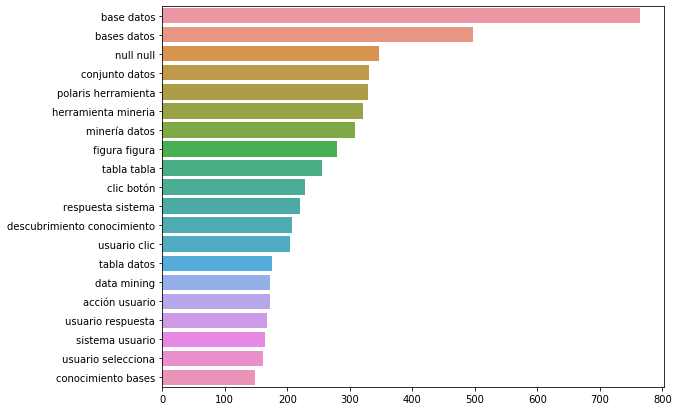

In [31]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]

grupo=11
df=df_tesis[df_tesis.grupo==grupo]
top_n_bigrams=get_top_ngram(df['contenido'].dropna(),2)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)
plt.savefig('./Imagenes/grupo_bigram'+str(grupo)+'.png')
#grupo 42 entornos virtuales de aprendizaje
#grupo 41 arquitectura obras y artes
#grupo 40 resevas naturales y sistemas agroforestales
#grupo 39 musica
#grupo 38 desarrollo poblacional
#grupo 37 ing civil 
#grupo 36 casos de uso UML
#grupo 35 ciencias y estadísicas  en alimentos
#grupo 34 informatica , fisica y matematicas 
#grupo 33 educacion y pedagogia
#grupo 32 estadística
#grupo 31 artes 
#grupo 30 desarrollo sostenible
#grupo 29 talento humano y organizaciones 
#grupo 28 estadistica en plantas yy granos
#grupo 27 derecho y leyes
#grupo 26 comercio
#grupo 25 quimica
#grupo 24 auditoria y sistemas de informacion 
#grupo 23 deserción estudiantil 
#grupo 22 materias primas  salud
#grupo 21
#grupo 20 mercados
#grupo 19 spsicologia
#grupo 18 bases de datos 
#grupo 17 orden teritorial 
#grupo 16 finanzas
#grupo 15 derechos humanos
#grupo 14 educacion familiares
#grupo 13 comercio exterior
#grupo 12 comindad social y politica
#grupos 11 programa de sistemas
#grupo 10 problemas sociales
#grupo 9 ing civil
#grupo 8 ciencias 
#grupo 7 medicina veterinaria
#grupo 6 ingles
#grupo 5 matriz dofa y planes estrategicos
#grupo 4 volcanes y base de datos
#grupo 3 educacion superiror y ciencias sociales
#grupo 2 cultivos suelos plantas y especies agro
#grupo 1 recursos naturales  medio ambiente 
#grupo 0 cultura y sociedad

# Trigramas mas Frecuentes por grupo 

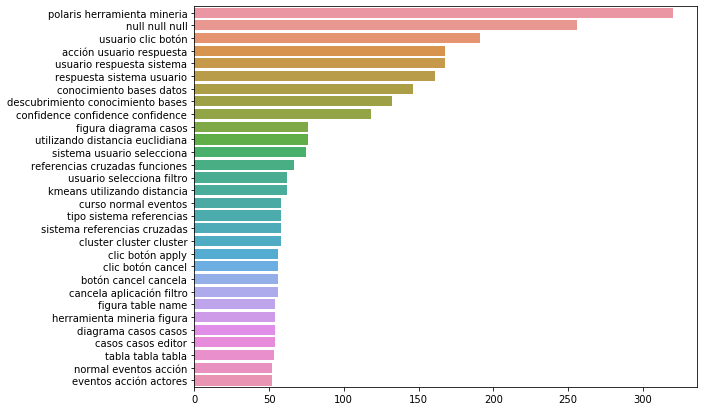

In [32]:
grupo=11
df=df_tesis[df_tesis.grupo==grupo]
top_tri_grams=get_top_ngram(df['contenido'].dropna(),n=3)
x,y=map(list,zip(*top_tri_grams))
plt.figure(figsize=(9,7))
sns.barplot(x=y,y=x)

# Modelo de Topicos

In [37]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['contenido'].dropna():
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

grupo=11
df=df_tesis[df_tesis.grupo==grupo]
#df=df_tesis
corpus=preprocess_news(df)
dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dic,                                    
                                   passes = 20,
                                   workers = 2)

In [34]:
lda_model.show_topics()

[(0,
  '0.022*"datos" + 0.019*"tabla" + 0.011*"figura" + 0.010*"atributos" + 0.009*"base" + 0.009*"atributo" + 0.007*"clase" + 0.007*"función" + 0.007*"reglas" + 0.007*"árbol"'),
 (1,
  '0.011*"datos" + 0.010*"null" + 0.010*"nodo" + 0.009*"figura" + 0.009*"tabla" + 0.009*"función" + 0.008*"plan" + 0.007*"relación" + 0.006*"base" + 0.006*"atributos"'),
 (2,
  '0.022*"datos" + 0.020*"figura" + 0.018*"distancia" + 0.012*"tabla" + 0.011*"algoritmo" + 0.011*"clase" + 0.011*"clustering" + 0.010*"clúster" + 0.008*"atributos" + 0.008*"algoritmos"'),
 (3,
  '0.022*"datos" + 0.018*"figura" + 0.018*"usuario" + 0.013*"tabla" + 0.011*"herramienta" + 0.011*"sistema" + 0.009*"base" + 0.009*"filtro" + 0.006*"nombre" + 0.005*"clase"')]

# Visualizar Topicos

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.067884  0.081320       1        1  40.762337
2     -0.125965  0.004332       2        1  32.800732
1      0.058081 -0.085651       3        1  26.436932, topic_info=              Term        Freq       Total Category  logprob  loglift
1619   herramienta  930.000000  930.000000  Default  30.0000  30.0000
4497        filtro  633.000000  633.000000  Default  29.0000  29.0000
11542      polaris  353.000000  353.000000  Default  28.0000  28.0000
2107       mineria  303.000000  303.000000  Default  27.0000  27.0000
1063     distancia  576.000000  576.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
2264       objetos  161.436554  548.663818   Topic3  -5.6679   0.1070
1746   información  157.396423  544.107239   Topic3  -5.6932   0.0900
496         clases  146.766388  423.501892   Topic3  -5.7631   0.2707
659       conexión  139.572906  360.564453   Topic3  -5.8134   0.3813
2259        número  145.353775  605.316040   Topic3  -5.7728  -0.0962

[258 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
134        1  0.570053   algoritmo
134        2  0.266112   algoritmo
134        3  0.164363   algoritmo
135        1  0.582110  algoritmos
135        2  0.286376  algoritmos
...      ...       ...         ...
10730      1  0.989977  waycluster
3380       1  0.164542       árbol
3380       2  0.626825       árbol
3380       3  0.208419       árbol
3390       1  0.993031    ítemsets

[422 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [36]:
pyLDAvis.save_html(vis, './output_filename.html')

In [34]:
from IPython.display import display, HTML
grupo=42
df=df_tesis[df_tesis.grupo==grupo]
df
display(HTML(df.head().to_html()))
len(df)

134

# Encuentra documentos similares

<font color='red' size='4'>Metodo 1: Usando Doc2vec</font>

In [11]:

def prepare_similarity(vectors):
    similarity=cosine_similarity(vectors)
    return similarity

def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [(i,sentence_list[i]) for i in indices]


module_url = "./Modelos/modelo_dm0_20_2000.txt" 
embed = gensim.models.doc2vec.Doc2Vec.load(module_url)



grupo=18
df=df_tesis[df_tesis.grupo==grupo]
df.reset_index(inplace=True)


  

sentence_list=df.contenido.values.tolist()
sentence=sentence_list[5]






In [12]:
embed_vectors=[]

import nltk
#nltk.download('stopwords')
import es_core_news_sm
nlp = es_core_news_sm.load()
stop=set(stopwords.words('spanish'))
def limpiar(text):
  text=text.lower()
  doc = nlp(text,disable = ['ner', 'parser'])
  #lemmas = [t.norm_ for t in doc if not t.is_punct | t.is_stop and t not in stop]
  lemmas = [t.norm_ for t in doc if not t.is_punct | t.is_stop ]
  words = [t.lower() for t in lemmas if len(t) > 3 and t.isalpha()]
  return words



def inferir_df(modelo,df):
  obs=df.contenido
  ids=df.id_documento
  id_documento=[]
  arrays=[]
  i=0
  while i<len(df):
    #arrays.append(modelo.infer_vector(limpiar(obs[i])))
    arrays.append(modelo.docvecs[i])
    id_documento.append(ids[i])
    i=i+1
  
  a=np.asarray(arrays)

  #df_doc2vec=pd.DataFrame(data=a[0:,0:],
   #         index=id_documento,
      #      columns=['v'+str(i) for i in range(a.shape[1])])

  return(a)


def inferir_df2(modelo,df):
  obs=df.contenido
  ids=df.id_documento
  id_documento=[]
  arrays=[]
  i=0
  while i<len(df):
    arrays.append(modelo.infer_vector(limpiar(obs[i])))
    #arrays.append(modelo.docvecs[i])
    id_documento.append(ids[i])
    i=i+1
  
  a=np.asarray(arrays)

  #df_doc2vec=pd.DataFrame(data=a[0:,0:],
   #         index=id_documento,
      #      columns=['v'+str(i) for i in range(a.shape[1])])

  return(a)
#embed.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
#embed_vectors=inferir_df(embed,df)

In [8]:
#print("Find similar research papers for :")
#print(sentence)
#sentence='mate apriori'
#similarity_matrix=prepare_similarity(embed_vectors)
#similar=get_top_similar(sentence,sentence_list,similarity_matrix,6)

#similar

In [13]:
nlp=spacy.load('es_core_news_sm')
sent_vecs={}
docs=[]

for i in tqdm(df['contenido'].fillna('unknown')[:1000]):
    doc=nlp((i)) 
    docs.append(doc)
    sent_vecs.update({i :doc.vector})

100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:59<00:00,  1.01s/it]


In [14]:
sentences=list(sent_vecs.keys())
vectors=list(sent_vecs.values())
x=np.array(vectors)
dbscan=DBSCAN(eps=0.08, min_samples=2,metric='cosine' ).fit(x)
df_cluster=pd.DataFrame({'sentences':sentences,'label':dbscan.labels_})

In [15]:
df_cluster.label.unique()
df_cluster[(df_cluster['label']==0)].head()

,sentences,label
0,tema titulo implementacion modulo manejo inven...,0
1,inicio sesión análisis diseño orientado objeto...,0
2,resumen sistemas información computarizados ma...,0
3,razones desarrollado ambiente edición construc...,0
4,descripcion problema implementación balanced s...,0


# Minería Artículos relacionados

Mi acercamiento <br></br>
Primero agregue artículos de todas las fuentes  <br></br>
Elija una subtarea de la tarea anterior  <br></br>
Encuentra artículos relacionados  <br></br>
Forme una lista de resumen de estos artículos  <br></br>
Luego, extraiga las palabras clave para obtener palabras clave importantes de estos trabajos de investigación.

In [16]:
all_articles=df_tesis.copy()
all_articles.drop(columns=['grupo'],inplace=True)

tasks=["descubrimiento de conocimiento de bases de datos",
      "mate algoritmos para clasificación apiori minería de datos",
      "sistemas de información",
      "casos de uso uml y casos de prueba",
      "maskana y onologías",
      "ricardo timaran pereira",
      "árboles de desición"]
task_df=pd.DataFrame({'contenido':tasks,'source':'task'})
task_df.head()
#all_articles['source']='article'

,contenido,source
0,descubrimiento de conocimiento de bases de datos,task
1,mate algoritmos para clasificación apiori mine...,task
2,sistemas de información,task
3,casos de uso uml y casos de prueba,task
4,maskana y onologías,task


In [17]:
embed_vectors=inferir_df(embed,all_articles)
all_articles=pd.concat([all_articles,task_df])
all_articles.reset_index(inplace=True)
all_articles.id_documento=all_articles.index+1
all_articles

,index,id_documento,contenido,source
0,0,1,monica patricia solis urbano jaime mejia jurad...,NaN
1,1,2,juan pasto junio agradecimientos contribuido d...,NaN
2,2,3,aura cecilia torres burbano universidad nariño...,NaN
3,3,4,nota aceptación firma presidente jurado firma ...,NaN
4,4,5,herrera erazo omar ortiz rosero universidad na...,NaN
...,...,...,...,...
8107,2,8108,sistemas de información,task
8108,3,8109,casos de uso uml y casos de prueba,task
8109,4,8110,maskana y onologías,task
8110,5,8111,ricardo timaran pereira,task


In [18]:
df_t=all_articles[all_articles['source']=='task']
df_t.reset_index(inplace=True)
df_t
embed_vectors2=inferir_df2(embed,df_t)


In [19]:
vectores=np.concatenate((embed_vectors,embed_vectors2),axis=0)
similarity_matrix=prepare_similarity(vectores)
#from joblib import dump, load
#dump(embed_vectors, './Datos/vectors.joblib') 

In [20]:
sentence= 'descubrimiento de conocimiento de bases de datos'
sentence_list=all_articles.contenido.values.tolist()

similar=get_top_similar(sentence,sentence_list,similarity_matrix,10)

In [22]:
for sent in similar:
    print("Trabajos:",sent[1])

Trabajos: descubrimiento de conocimiento de bases de datos
Trabajos: construcción ontología aplicación soporte búsqueda inteligente trabajos grado universidad nariño utilizando herramienta software libre protégé omar ernesto cabrera rosero jimmy mateo guerrero restrepo mauricio fernando benavides benavides universidad nariño facultad ingeniería programa ingeniería sistemas juan pasto free share copy distribute transmit this work remix adapt this work under following conditions attribution must attribute work manner specified author licensor that suggests that they endorse your work share alike alter transform build upon this work distribute resulting work only under same similar license this conclusiones apéndices protégé distribuciones basadas debian realización ontología protégé aplicación prueba datos introducción falta significado maneja actual dificulta búsqueda eficiente información proyecto propone construcción ontología trabajos grado estudiantes pregrado universidad nariño uti

Limpie y almacene resúmenes de artículos relacionados.

In [65]:
import re
def clean(txt):
    txt=re.sub(r'\n','',txt)
    txt=re.sub(r'\([^()]*\)','',txt)
    txt=re.sub(r'https?:\S+\sdoi','',txt)
    return txt

In [66]:
ind,title=list(map(list,zip(*similar)))
texts=[]
for i in ind:
    texts.append(all_articles.iloc[i]['contenido'])

In [67]:
texts=list(map(clean,texts))
text_list=' '.join(texts)
#text_list=word_tokenize(text_list)


##  Extracción de palabras clave

La extracción de palabras clave es el proceso automatizado de extracción de las palabras y expresiones más relevantes del texto. La extracción de palabras clave (también conocida como detección de palabras clave o análisis de palabras clave) es una técnica de análisis de texto que consiste en extraer automáticamente las palabras y expresiones más importantes en un texto. Ayuda a resumir el contenido de un texto y reconocer los principales temas que se están discutiendo.

In [144]:
!pip install python-rake

  Created wheel for python-rake: filename=python_rake-1.4.5-py3-none-any.whl size=13485 sha256=832b51b7616450864b5e8809cb6c4ad5f6508ecb89486f86935640bfb4db1869
  Stored in directory: c:\users\jbarco\appdata\local\pip\cache\wheels\17\a4\a3\f2096f940a9ff09c685f4abb7a6df62dd8cac4e09b7e67b99b
Successfully built python-rake


In [68]:
# Reka
import RAKE
import operator
from nltk.corpus import stopwords

stop=list(stopwords.words('spanish'))

# Reka setup with stopword directory
#stop_dir = stop
rake_object = RAKE.Rake(stopwords=stop)

# Sample text to test RAKE



# Extract keywords
keywords = rake_object.run(text_list)

TypeError: __init__() got an unexpected keyword argument 'stopwords'

In [69]:
words,score=list(map(list,zip(*keywords)))
for word in (words[:10]):
    print(word)

NameError: name 'keywords' is not defined

### Método 2: PytextRank

In [159]:
!pip install pytextrank

In [70]:
import logging
import pytextrank
import spacy
import sys


In [72]:
nlp = spacy.load('es_core_news_sm')
stop=set(stopwords.words('spanish'))


logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logger = logging.getLogger("PyTR")

# add PyTextRank into the spaCy pipeline

tr = pytextrank.TextRank(logger=None)
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

# parse the document

doc = nlp(text_list)

print("pipeline", nlp.pipe_names)
print("elapsed time: {} ms".format(tr.elapsed_time))


pipeline ['tagger', 'parser', 'ner', 'textrank']
elapsed time: 17800.395965576172 ms


In [73]:
for phrase in doc._.phrases[:50]:
    print("{}".format(phrase.text))
    #print(phrase.chunks)

conocimiento base datos
base datos
departamento base datos
maestro base datos
conexión base datos
base datos módulo herramienta
conexión base datos submódulo base datos diccionario vocabulario glosario términos
aplicación base datos caso nombre
sopa letras nombre adivinazas descripción tabla base datos adivinanzas área
código base datos campos requeridos
objeto base datos microsoft
departamento nariño datos
seacis proceso nombre videos descripción
maestro base datos archivo flujos entrada flujos salida maestro base
maestro base datos archivo almacén
keywordfacade clase lineainvestigaciònfacade clase modalidadfacade clase palabrafacade clase programafacade clase significadofacade clase tgautorfacade clase trabajosgradofacade clase usuarioaplicaciònfacade clase usuariofacade clase vocabulariofacade
registro construcción descripción información generada proceso edición proyecto investigación construir
código objeto código investigación nombre original nombre servidor tipo
tipo nombre
desc

## Gráfico de conocimiento

A continuación, trataremos de dibujar un gráfico de conocimiento de los documentos relacionados que encontramos.

In [74]:
import spacy
nlp=spacy.load('es_core_news_sm')

In [75]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

  #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                   prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
              modifier = prv_tok_text + " "+ tok.text

          ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

          ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

          ## chunk 5  
          # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
  #############################################################

    return [ent1.strip(), ent2.strip()]

In [76]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

## Pregunta: ¿Cuál es el papel del medio ambiente en la transmisión?

Prepararemos un marco de datos que contenga, sujeto, relación y objeto de estos resúmenes para trazar el gráfico de conocimiento.

In [77]:
def prepare_df(text_list):
    doc=nlp(text_list)
    df=pd.DataFrame()
    for sent in list(doc.sents):
        sub,obj = get_entities(str(sent))
        relation= get_relation(str(sent))

        if ((len(relation)>2) & (len(sub)>2) &(len(obj)>2)):
            df=df.append({'subject':sub,'relation':relation,'object':obj},ignore_index=True)

    return df

In [78]:
df = prepare_df(text_list[24:])
df.head(n=100)

,object,relation,subject
0,variables procedimientos,demostró,presupuestadas desarrollo
1,usuario usuario,realiza,clases paquete
2,recolectadas seleccione fácil,muestra,actual analyzer
3,totalmente independiente,ofrece,nodos test
4,información progress,permite,desarrollada proyecto


In [79]:
def draw_kg(pairs,c1='red',c2='blue',c3='orange'):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
  
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(50, 40), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color=c1,
        edgecolors=c2,
        node_color=c3,
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

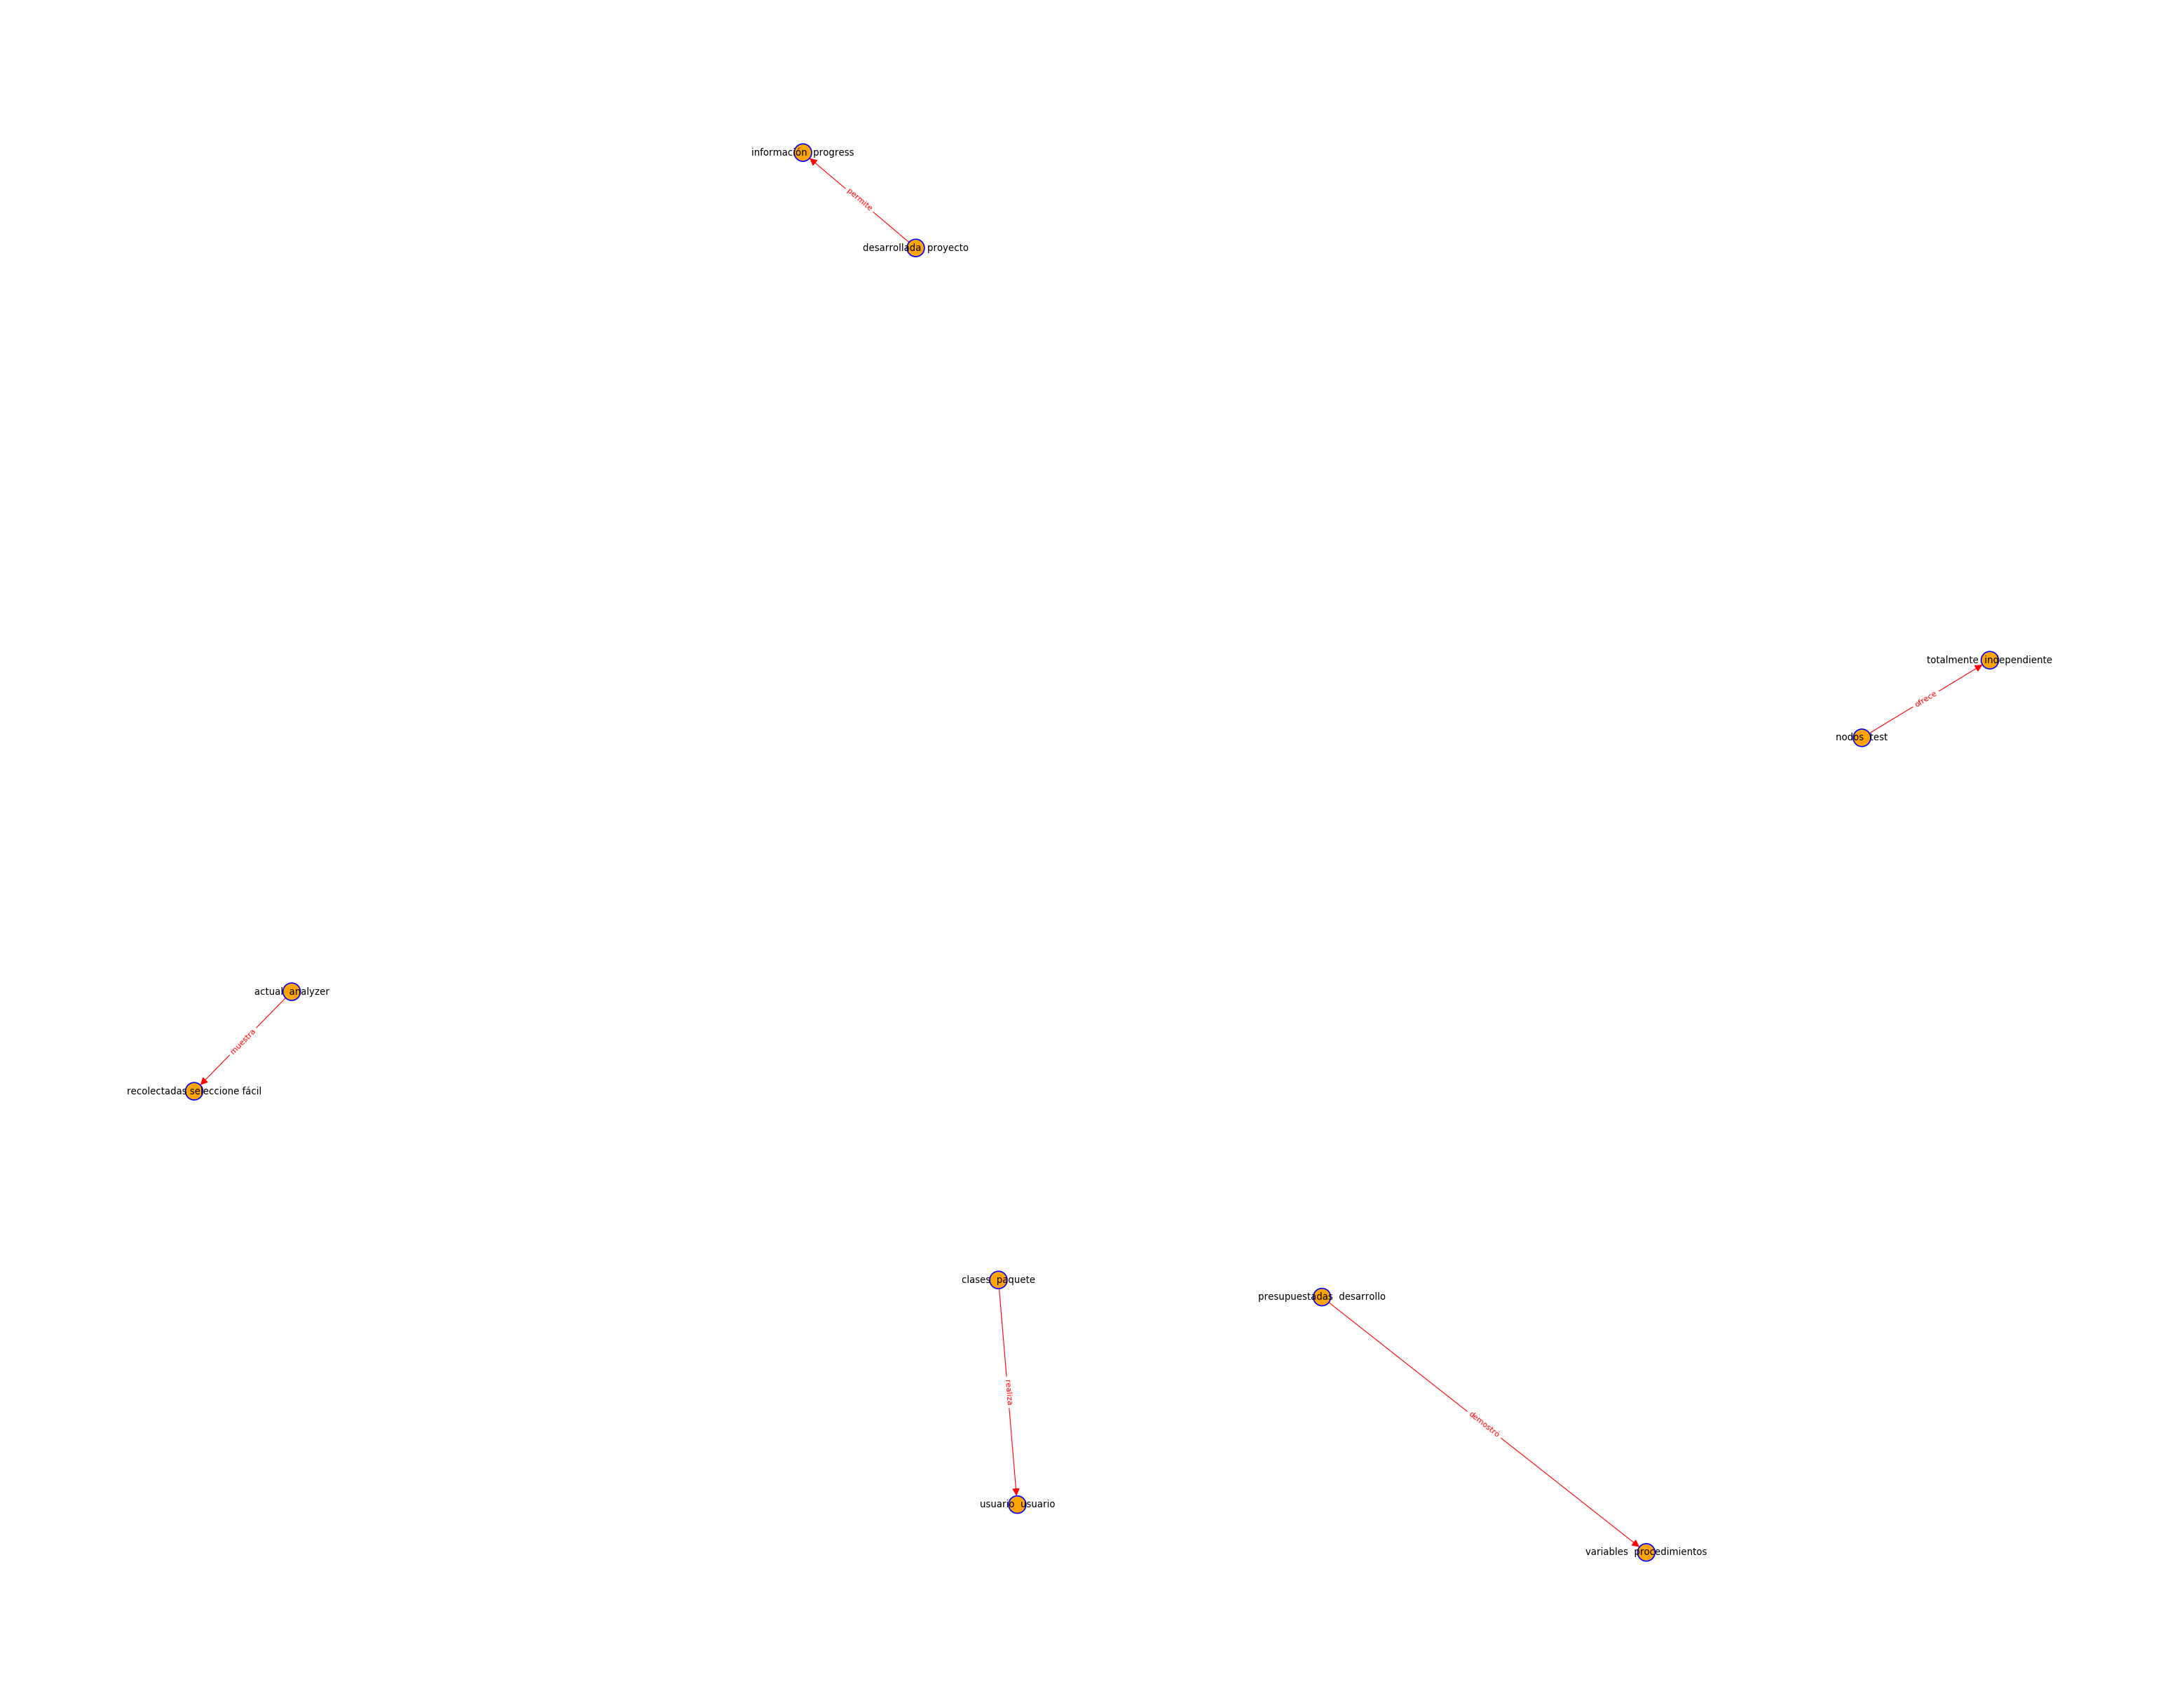

In [80]:
draw_kg(df)

## Relaciones conceptuales

Temáticas 
Taxonómicas  :  vinculan a conceptos de una misma categoría semántica


In [26]:
df=pd.read_csv("./resumenes_limpios.csv",index_col=0,sep='|')
df = df.dropna().drop_duplicates()

df_grupos=pd.read_csv("./tesis_grupos.csv",sep="|")
df_grupos=df_grupos[['id_documento','grupo']]

#Cruzar Textos
df_tesis= pd.merge(df, df_grupos, on='id_documento')
df_tesis


,id_documento,contenido,grupo
0,1,monica patricia solis urbano jaime mejia jurad...,23
1,2,juan pasto junio agradecimientos contribuido d...,34
2,3,aura cecilia torres burbano universidad nariño...,27
3,4,nota aceptación firma presidente jurado firma ...,20
4,5,herrera erazo omar ortiz rosero universidad na...,12
...,...,...,...
8100,8167,universidad manizales facultad ciencias ingeni...,11
8101,8169,clasificacion modelo clasificacion tipos probl...,11
8102,8170,introduction this document designed reference ...,6
8103,8171,maskana gestor conocimiento recuperación búsqu...,11


In [48]:
grupo=36
df=df_tesis[df_tesis.grupo==grupo]

def extrac_texto(df):
    texto=''
    for t in df.contenido:
        texto=texto+"\n "+t
    return texto

texto=extrac_texto(df)    

In [49]:
#librerias 
import pandas as pd
import numpy  as np
import spacy.cli
import spacy
import re 
from ftfy import fix_encoding
from spacy import displacy
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency
from gensim.models import Word2Vec
import multiprocessing
from time import time  # To time our operations

In [34]:
nlp = spacy.load('es_core_news_sm')
texto = re.sub('[ \t\n]+', ' ', texto) 
texto=fix_encoding(texto)
nlp.max_length = 2341047 
doc=nlp(texto)

In [39]:
#Recopilar conceptos
def reconocer_conceptos(texto):
    conceptos=""
    for palabra in doc.ents:
        p=palabra.text.replace(" ","_")
        for t in palabra.text.split(' '):
            d1=nlp(t.lower())
            for ent in  d1:
                if not ent.is_punct and not ent.is_stop and len(ent)>1:
                    conceptos=str(conceptos)+" "+str(ent)
    return conceptos
def tokenize(text):
    text=text.lower()
    doc1 = nlp(text)
    lemmas = [t.norm_ for t in doc1 if not t.is_punct | t.is_stop]
    #lemmas = [t.lemma_ for t in doc1 if not t.is_punct | t.is_stop]
    words = [t.lower() for t in lemmas if len(t) > 1 and t.isalpha()]
    return words
conceptos=reconocer_conceptos(texto)
conceptos=tokenize(conceptos)


In [56]:
sent=[]
for num,oracion in enumerate(doc.sents):
    o=tokenize(str(oracion))
    sent.append(o) 
#Crea las frases relevantes de la lista de oraciones:
phrases = Phrases(sent, min_count=30, progress_per=10000)
#Transforme el corpus en función de las bigramas detectadas:
bigram = Phraser(phrases)
sentences = bigram[sent]
#palabras mas frecuentes
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['sistema',
 'datos',
 'información',
 'usuario',
 'caso',
 'consultar',
 'modificar',
 'figura',
 'administrador',
 'nombre']

In [57]:

#Entrenamiento del modelo
cores = multiprocessing.cpu_count() #cuenta el nro de nucles de la pc

w2v_model = Word2Vec(min_count=2,
                     window=3,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)
t = time()
w2v_model.build_vocab(sentences,progress_per=10000)  # prepare the model vocabulary
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
t = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=6000, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins
Time to train the model: 66.63 mins


In [62]:
#Explorar el modelo
w2v_model.init_sims(replace=True)
w2v_model.wv.most_similar(positive=['actor'.lower()])

[('inicia', 0.4502812623977661),
 ('pantalla', 0.3716910481452942),
 ('caso_comienza', 0.3612738251686096),
 ('cursos_alternos', 0.35786670446395874),
 ('curso_normal', 0.3568649888038635),
 ('eventos_acción', 0.3555818796157837),
 ('consulta', 0.3305370509624481),
 ('visualiza', 0.33017247915267944),
 ('actores_respuesta', 0.32809963822364807),
 ('línea_línea', 0.3113165497779846)]

C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method w

C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\JBARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method w

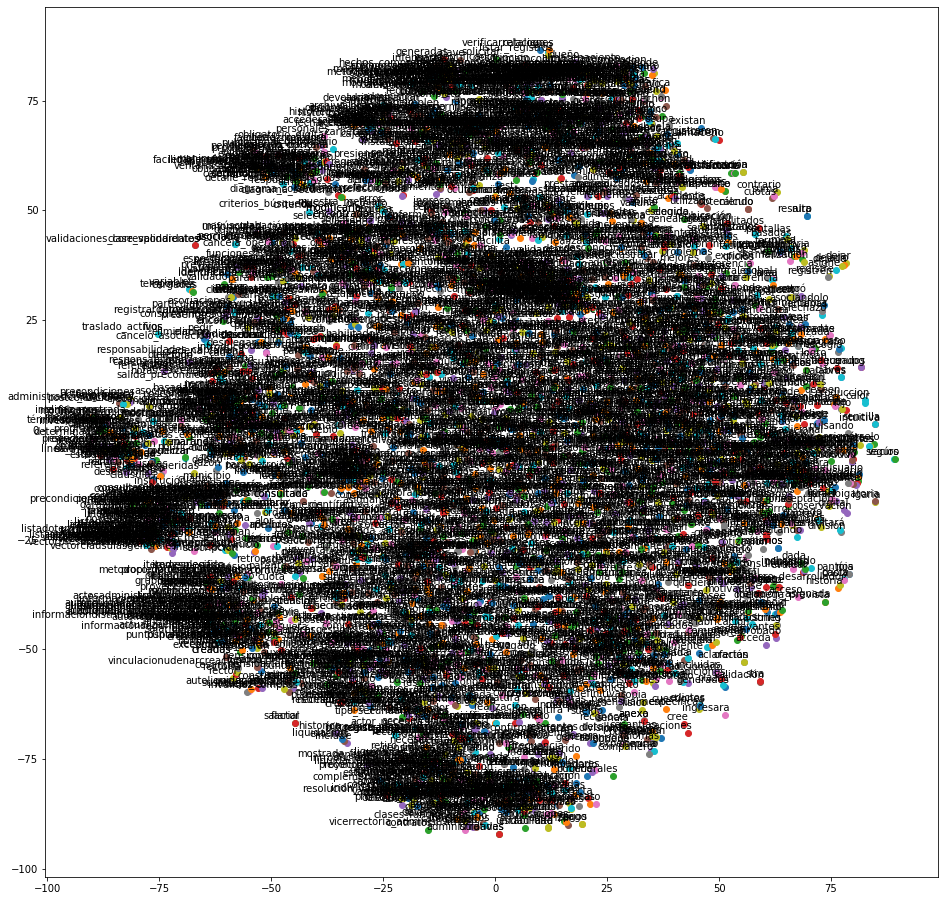

In [63]:
#https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
#https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('./Imagenes/relaciones.png')
    plt.show()
    
    
def mapa_conceptual(model,conceptos):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in conceptos:
        try:
            tokens.append(model[word])
            labels.append(word)
        except KeyError:
            continue
        

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(7, 7)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model)

In [2]:
df=pd.read_csv("./resumenes_limpios.csv",index_col=0,sep='|')
df = df.dropna().drop_duplicates()

df_grupos=pd.read_csv("./tesis_grupos.csv",sep="|")
df_grupos=df_grupos[['id_documento','grupo']]

#Cruzar Textos
df_tesis= pd.merge(df, df_grupos, on='id_documento')
df_tesis

,id_documento,contenido,grupo
0,1,monica patricia solis urbano jaime mejia jurad...,23
1,2,juan pasto junio agradecimientos contribuido d...,34
2,3,aura cecilia torres burbano universidad nariño...,27
3,4,nota aceptación firma presidente jurado firma ...,20
4,5,herrera erazo omar ortiz rosero universidad na...,12
...,...,...,...
8100,8167,universidad manizales facultad ciencias ingeni...,11
8101,8169,clasificacion modelo clasificacion tipos probl...,11
8102,8170,introduction this document designed reference ...,6
8103,8171,maskana gestor conocimiento recuperación búsqu...,11


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [11]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return nlp(no_url)

In [ ]:
from string import punctuation
nlp = spacy.load('es_core_news_sm')

grupo=36
df=df_tesis[df_tesis.grupo==grupo]

text_no_urls = [remove_url(str(t)) for t in list(df.contenido)]

# Create a sublist of lower case words for each tweet
words_in_text = [nlp(str(t).lower()) for t in list(text_no_urls)]

# Download stopwords
#nltk.download('stopwords')
#stop_words = set(stopwords.words('spanish'))

# Remove stop words from each tweet list of words
#texto_limpio = [[word for word in t_w if not str(word) in stop_words]
#              for t_w in words_in_text]

#texto_limpio = [[word for word in t_w if not str(word) in punctuation]
#              for t_w in tweets_nsw]
texto_limpio=words_in_text


# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(t)) for t in list(texto_limpio)]

# View bigrams for the first tweet
terms_bigram

In [27]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(50)

[((diseño, orientado), 1),
 ((orientado, objetos), 1),
 ((objetos, desarrollo), 1),
 ((desarrollo, aplicativo), 1),
 ((aplicativo, permita), 1),
 ((permita, generación), 1),
 ((generación, reportes), 1),
 ((reportes, dinámicos), 1),
 ((dinámicos, estadísticos), 1),
 ((estadísticos, información), 1),
 ((información, oficinas), 1),
 ((oficinas, avalúo), 1),
 ((avalúo, conservación), 1),
 ((conservación, igac), 1),
 ((igac, casos), 1),
 ((casos, reales), 1),
 ((reales, iniciar), 1),
 ((iniciar, sesión), 1),
 ((sesión, creación), 1),
 ((creación, usuarios), 1),
 ((usuarios, insertar), 1),
 ((insertar, archivos), 1),
 ((archivos, vigencias), 1),
 ((vigencias, anteriores), 1),
 ((anteriores, migrar), 1),
 ((migrar, vigencias), 1),
 ((vigencias, anteriores), 1),
 ((anteriores, obtener), 1),
 ((obtener, estadísticas), 1),
 ((estadísticas, eliminar), 1),
 ((eliminar, estadísticas), 1),
 ((estadísticas, consultar), 1),
 ((consultar, radicaciones), 1),
 ((radicaciones, tramitadas), 1),
 ((tramita

In [24]:
bigram_df = pd.DataFrame(bigram_counts.most_common(50),
                             columns=['bigram', 'count'])
bigram_df

,bigram,count
0,"(diseño, orientado)",1
1,"(orientado, objetos)",1
2,"(objetos, desarrollo)",1
3,"(desarrollo, aplicativo)",1
4,"(aplicativo, permita)",1
5,"(permita, generación)",1
6,"(generación, reportes)",1
7,"(reportes, dinámicos)",1
8,"(dinámicos, estadísticos)",1
9,"(estadísticos, información)",1


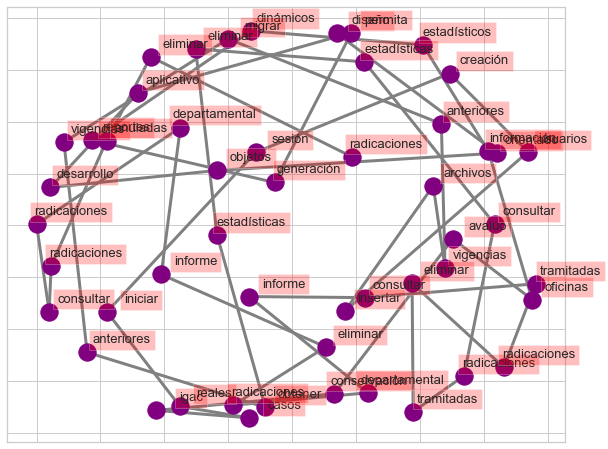

In [35]:
# Create network plot 
d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=str(key),
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()